# Project 4, APS1070 Fall 2020
#### **Linear Regression -  20 points**
**Deadline: Nov 29, 23:59**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Your **name**: Yonghao Li
*   Your **student number**: 1004905668



## Part 1 - Getting Started [1 mark]

In Parts 1- 6 of this project, we are designing a controller to manage the ailerons of an F16 Aircraft! 

![Ailerons](https://raw.githubusercontent.com/aps1070-2019/datasets/master/img/airplane.gif) [Ref](https://www.grc.nasa.gov/www/k-12/BGA/Mike/airplane_parts_act.htm) 


The features describe the airplane's status, and our goal is to predict the `Goal` column, which is a command that our controller should issue. We will make our predictions by implementing linear regression without regularization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.linalg import inv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

1. Print the dataframe.
2. Prepare your dataset as follows: **[1]**
*   Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.
*   Standardize the data using StandardScaler from sklearn.
*   Insert a first column of 1s in both the training and validation data sets.


In [2]:
df.head(10)

,inputs ClimbRate,Sgz,P,Q,CurPitch,CurRoll,AbsRoll,DiffClb,DiffRollRate,DiffDiffClb,SeTime1,SeTime2,SeTime3,SeTime4,SeTime5,SeTime6,SeTime7,SeTime8,SeTime9,SeTime10,SeTime11,SeTime12,SeTime13,SeTime14,DiffSeTime1,DiffSeTime2,DiffSeTime3,DiffSeTime4,DiffSeTime5,DiffSeTime6,DiffSeTime7,DiffSeTime8,DiffSeTime9,DiffSeTime10,DiffSeTime11,DiffSeTime12,DiffSeTime13,DiffSeTime14,Alpha,Se,Goal
0,-17,-6,-0.03,0.14,0.59,-0.5,-11,-9,0.015,-0.2,0.019,0.019,0.019,0.020,0.020,0.020,0.020,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.000,0.0,-0.002,0.0,0.0,0.0,-0.002,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.6,0.021,-0.0008
1,-791,15,-0.28,-0.34,1.11,0.9,-10,27,-0.002,4.7,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.4,0.013,-0.0009
2,-46,48,-0.42,0.07,0.57,0.6,-5,-8,-0.008,0.0,0.018,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,-0.002,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.019,-0.0005
3,496,-5,-0.21,-0.04,0.03,-0.5,-7,6,-0.002,-0.1,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.018,0.018,0.017,-0.001,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.001,0.0,0.001,0.0,0.5,0.017,-0.0005
4,-124,16,-0.02,0.05,0.61,-0.2,-9,-3,0.000,0.0,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.018,-0.0006
5,-253,19,0.01,0.22,1.17,0.2,-16,-10,-0.012,0.0,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.9,0.033,-0.0016
6,-420,-7,0.14,0.14,0.99,-1.7,-20,-6,0.025,0.9,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.6,0.021,-0.0012
7,-335,3,-0.13,0.03,0.82,1.7,-8,0,-0.009,-0.2,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.018,-0.0007
8,197,-50,0.27,-0.04,0.30,-1.5,-12,10,0.016,-0.1,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.017,-0.0007
9,-256,3,-0.17,0.08,0.77,-0.2,-13,-2,0.008,-0.2,0.018,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,-0.002,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.019,-0.0010


In [3]:
df.shape

(13750, 41)

In [4]:
## Train test split (80/20)
df_copy = df.copy(deep=True)
X = df_copy.iloc[:,:-1]
y = df_copy.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
## Standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
## Insert bias column
X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)

In [7]:
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

## Part 2 - Linear Regression - Direct Solution [2 marks]

Implement the direct solution to linear regression on the training set. **[1]**

Report the root-mean-square error (RMSE) for both the training and validation sets.**[1]**

In [8]:
def rmse(yPred, y):
  return np.sqrt(mean_squared_error(yPred, y))

In [9]:
W_ds = np.dot(inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))

ytrainPred = np.dot(X_train, W_ds)
ytestPred = np.dot(X_test, W_ds)

In [10]:
print('RMSE for training sets: ', rmse(ytrainPred, y_train))
print('RMSE for validation sets: ', rmse(ytestPred, y_test))

RMSE for training sets:  0.0001983241902503662
RMSE for validation sets:  0.0001874084898605524


In [11]:
rmse_ds = rmse(ytestPred, y_test)

## Part 3 - Full Batch Gradient Descent [2 marks]

We will now implement a full batch gradient descent algorithm and record the training time for our model.

1. Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 1e-2$, and by iterating until your model's validation RMSE converges. Here we will consider it converged once validation RMSE is within 0.1% of the Direct Solution RMSE (i.e., $RMSE_{GD} <= RMSE_{Direct Solution}*1.001$). We call this value **Convergence threshold ($CT = RMSE_{Direct Solution}*1.001$)** and will use this value in the next parts too.

  *  Record the training time (from the first iteration until convergence) using the `time.time()` function. Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial.**[0.5]**

  * Plot the Training RMSE and the Validation RMSE vs epoch on the same figure. Epoch is the number of passes on the full training set - for full batch gradient descent, it's the same as the # of gradient updates (iterations). **[0.5]**

2. Comment on overfitting/underfitting - is running the algorithm too long a concern here? **[1]**

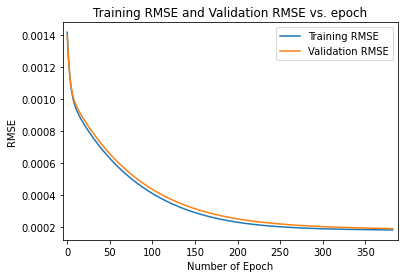

--- Total Training Time: 0.7086071968078613 (s) ---


In [12]:
import time

start_time = time.time() ## Records current time
lr = 0.01
ct = rmse_ds * 1.001
w = (np.random.random(X_train.shape[1])/10000).reshape(1,-1) ## Initialize weights
rmse_train = []
rmse_test = []
rmse_fb = 1
epoch = 0

while rmse_fb > ct:
    ytrain_fb = np.dot(X_train, w.T).reshape(-1,1)
    rmse_train.append(rmse(ytrain_fb, y_train))
    gradient = (1/len(ytrain_fb) * np.dot(X_train.T, ytrain_fb-y_train)).reshape(1,-1)
    ytest_fb = np.dot(X_test, w.T).reshape(-1,1)
    rmse_fb = rmse(ytest_fb, y_test)
    rmse_test.append(rmse_fb)
    w = w - lr * gradient
    epoch += 1

plt.plot(range(epoch), rmse_train, label='Training RMSE')
plt.plot(range(epoch), rmse_test, label='Validation RMSE')
plt.xlim(-5, epoch + 5)
plt.legend()
plt.title('Training RMSE and Validation RMSE vs. epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('RMSE')
plt.show()

print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))

In general, checking RMSE of the model can help us determine if the model is overfitting or underfitting:
- If the training RMSE is low while the validation RMSE remains high, then the model is likely overfitting;
- If both training RMSE and validation RMSE remain high, then the model is likely underfitting;
- We should try to make sure that both training RMSE and validation RMSE are low.

For full batch gradient descent, running the algorithm too long is a concern because it means that convergence is hard to reach. This might be due to bad weight-initialization or inappropriate learning rate alpha. Adjusting initial weights should fix this problem.

## Part 4 - Mini-batch and Stochastic Gradient Descent [4 marks]

Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached.**[1]** The inputs of that function are 
  * Training Data
  * Validation Data
  * Batch size
  * Learning Rate
  * Convergence Threshold (CT)
  * Maximum Iterations = 20000

Your function will return the following arrays: 
 * The final weights after training.
 * The training RMSE at each epoch (the number of epochs is the number of passes on the full data set).
 * The validation RMSE at each epoch.
 * An array that has the elapsed time from the start of the training process to the end of each epoch (e.g., if each epoch takes exactly 2 seconds the array would look like: [2 4 6 8 ...]).
 * For certain batchsizes GD might not converge to a solution. For that reason we have a parameter "Maximum iterations" where we limit the total number of iterations that this function can perform. 

Let's now use the function to investigate the effect of batch size on convergence. When the batch size is 1, we call that stochastic gradient descent. When the batch size equals the # of training data, it is full-batch (ie all data points are used at every iteration). Anywhere in between is mini-batch (we use some of the data).
  * Sweep different values for the mini-batch size (at least 10 values, including 1 -- Stochastic GD), each time using a learning rate of $\alpha= 1e-2$. **Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,32,...).** These batchsizes fit better on the hardware and may achieve higher performance.  **[0.5]**
  * Plot training and validation RMSE vs. **epoch** for all the batchsizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE. **[0.5]**
  * Plot training and validation RMSE vs. **time** for all the batchsizes in a figure. The X-axis is Time and the Y-axis is RMSE. **[0.5]**
  * Plot Total training time (y-axis) vs. Batch size (x-axis). **[0.5]**
  * Describe your findings, including the main takeaways from each of your plots. **[1]**

In [13]:
## Main function for Part 4
def mini_batch_GD(training_data: np.ndarray, training_target: np.ndarray,
                  validation_data: np.ndarray, validation_target: np.ndarray,
                  batch_size: int, learning_rate: float, 
                  convergence_threshold: float, max_iter = 20000):
    ## Initialization
    np.random.seed(2)
    start_time = time.time()
    time_arr = []
    rmse_train = []
    rmse_test = []
    n = training_data.shape[0]
    w = (np.random.random(training_data.shape[1])/10000).reshape(1,-1)
    iter = 0
    row_num = 0

    ## Start of iteration
    while iter <= max_iter:
    ## Shuffle training data before each epoch
        xShuffled, yShuffled = shuffle(training_data, training_target)

        ## Start of each epoch
        for i in range(0, xShuffled.shape[0], batch_size):
            X_batch = xShuffled[i:i+batch_size]
            y_batch = yShuffled[i:i+batch_size]
            ytrain_mb = np.dot(X_batch, w.T).reshape(-1,1)
            gradient = (1/len(ytrain_mb) * np.dot(X_batch.T, ytrain_mb-y_batch)).reshape(1,-1)
            w = w - learning_rate * gradient ## Update weights
            iter += 1
            row_num = i

        if row_num < n: ## Consider cases when the last mini batch has less rows than batch size
            X_batch = xShuffled[row_num:]
            y_batch = yShuffled[row_num:]
            ytrain_mb = np.dot(X_batch, w.T).reshape(-1,1)
            gradient = (1/len(ytrain_mb) * np.dot(X_batch.T, ytrain_mb-y_batch)).reshape(1,-1)
            w = w - learning_rate * gradient ## Update weights
            iter += 1

        ## Collect info at the end of each epoch
        epoch_time = time.time() - start_time
        time_arr.append(epoch_time)

        ## Compute training RMSE
        ytrain_ep = np.dot(training_data, w.T).reshape(-1,1)
        rmse_train_ep = rmse(ytrain_ep, training_target)
        rmse_train.append(rmse_train_ep)

        ## Compute validation RMSE
        ytest_ep = np.dot(validation_data, w.T).reshape(-1,1)
        rmse_test_ep = rmse(ytest_ep, validation_target)
        rmse_test.append(rmse_test_ep)

        ## Check against threshold
        if rmse_test_ep <= convergence_threshold:
            break

    return w, rmse_train, rmse_test, time_arr

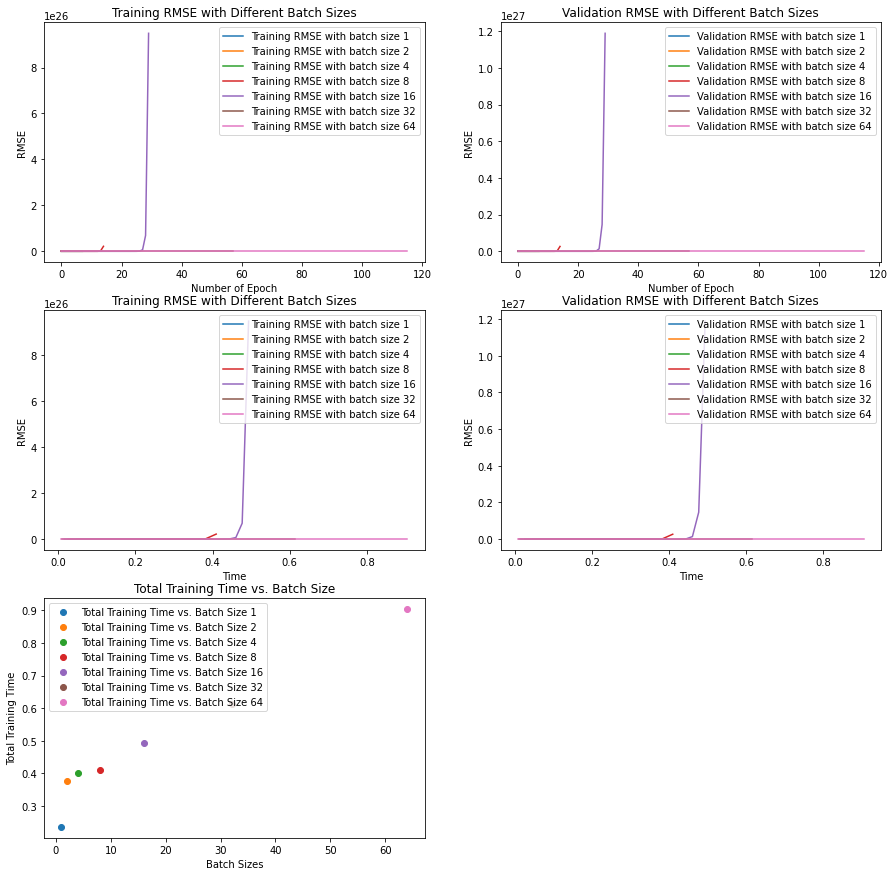

In [14]:
## Plotting diverging set of RMSE curves
batch_list = []
for i in range(0, 7):
    batch_list.append(2**i)

fig, axes = plt.subplots(3, 2, figsize=(15,15))

for i in batch_list:
    w, rmse_train, rmse_test, time_arr = mini_batch_GD(X_train, y_train, X_test, 
                                                    y_test, i, 0.01, ct, 20000)
    axes.flat[0].plot(rmse_train, label='Training RMSE with batch size '+ str(i))
    axes.flat[0].legend(loc='upper right')
    axes.flat[0].set(title='Training RMSE with Different Batch Sizes',
                    xlabel='Number of Epoch',
                    ylabel='RMSE')
    axes.flat[1].plot(rmse_test, label='Validation RMSE with batch size '+ str(i))
    axes.flat[1].legend(loc='upper right')
    axes.flat[1].set(title='Validation RMSE with Different Batch Sizes',
                    xlabel='Number of Epoch',
                    ylabel='RMSE')
    axes.flat[2].plot(time_arr, rmse_train, label='Training RMSE with batch size '+ str(i))
    axes.flat[2].legend(loc='upper right')
    axes.flat[2].set(title='Training RMSE with Different Batch Sizes',
                    xlabel='Time',
                    ylabel='RMSE')
    axes.flat[3].plot(time_arr, rmse_test, label='Validation RMSE with batch size '+ str(i))
    axes.flat[3].legend(loc='upper right')
    axes.flat[3].set(title='Validation RMSE with Different Batch Sizes',
                    xlabel='Time',
                    ylabel='RMSE')
    axes.flat[4].scatter(i, time_arr[-1], label='Total Training Time vs. Batch Size '+ str(i))
    axes.flat[4].legend(loc='upper left')
    axes.flat[4].set(title='Total Training Time vs. Batch Size',
                    xlabel='Batch Sizes',
                    ylabel='Total Training Time')

fig.delaxes(axes[2][1])

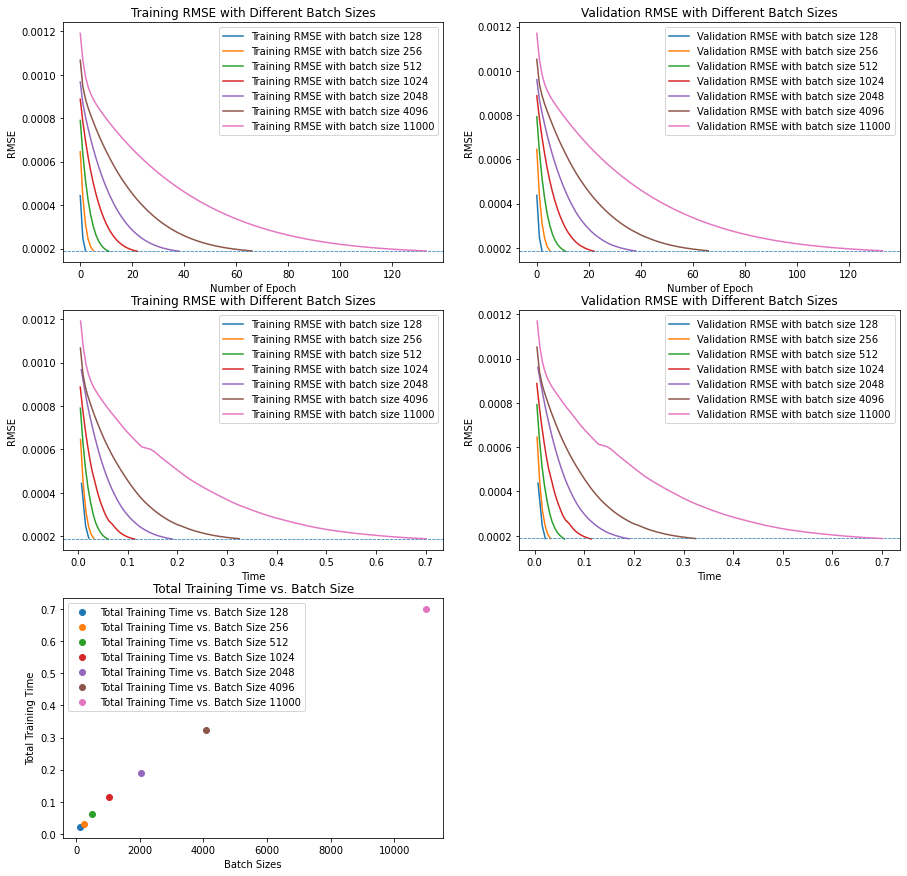

In [15]:
## Plotting converging set of RMSE curves
batch_list = []
for i in range(7, 13):
    batch_list.append(2**i)

batch_list.append(int(11000))
fig, axes = plt.subplots(3, 2, figsize=(15,15))

for i in batch_list:
    w, rmse_train, rmse_test, time_arr = mini_batch_GD(X_train, y_train, X_test, 
                                                    y_test, i, 0.01, ct, 20000)
    axes.flat[0].plot(rmse_train, label='Training RMSE with batch size '+ str(i))
    axes.flat[0].axhline(y=ct, linestyle = '--', linewidth = 0.8, alpha = 0.2)
    axes.flat[0].legend(loc='upper right')
    axes.flat[0].set(title='Training RMSE with Different Batch Sizes',
                    xlabel='Number of Epoch',
                    ylabel='RMSE')
    axes.flat[1].plot(rmse_test, label='Validation RMSE with batch size '+ str(i))
    axes.flat[1].axhline(y=ct, linestyle = '--', linewidth = 0.8, alpha = 0.2)
    axes.flat[1].legend(loc='upper right')
    axes.flat[1].set(title='Validation RMSE with Different Batch Sizes',
                    xlabel='Number of Epoch',
                    ylabel='RMSE')
    axes.flat[2].plot(time_arr, rmse_train, label='Training RMSE with batch size '+ str(i))
    axes.flat[2].axhline(y=ct, linestyle = '--', linewidth = 0.8, alpha = 0.2)
    axes.flat[2].legend(loc='upper right')
    axes.flat[2].set(title='Training RMSE with Different Batch Sizes',
                    xlabel='Time',
                    ylabel='RMSE')
    axes.flat[3].plot(time_arr, rmse_test, label='Validation RMSE with batch size '+ str(i))
    axes.flat[3].axhline(y=ct, linestyle = '--', linewidth = 0.8, alpha = 0.2)
    axes.flat[3].legend(loc='upper right')
    axes.flat[3].set(title='Validation RMSE with Different Batch Sizes',
                    xlabel='Time',
                    ylabel='RMSE')
    axes.flat[4].scatter(i, time_arr[-1], label='Total Training Time vs. Batch Size '+ str(i))
    axes.flat[4].legend(loc='upper left')
    axes.flat[4].set(title='Total Training Time vs. Batch Size',
                    xlabel='Batch Sizes',
                    ylabel='Total Training Time')

fig.delaxes(axes[2][1])

Findings and main takeaways:
- Since the max iteration is set at 20000, batch sizes from 1 to 64 did not converge within the function limit (using power of 2 list);
- Batch sizes larger than 64 when using power of 2 (128 upwards) did converge, while the larger batch sizes (1024, 2048, 4096) have smoother RMSE curves than the ones with smaller batch sizes;
- Most of the training RMSE curves and the validation RMSE curves follow very similar trajectories. However, when comparing the RMSE curves with larger training batch sizes, the validation RMSE seems to require a bit more number of epochs to reach the same RMSE as the training one;
- In general, larger batch sizes lead to longer training time used;
- The best batch size appears to be 128 because it produces a quickly-descending convergence RMSE curve in fewer epochs and less training time than the other batch sizes.

## Part 5 - Gradient Descent Learning Rate [2 marks]
Use the function that you designed in Part 4 to investigate the effect of learning rate on convergence.

Select the best batch size based on the fastest convergence time and sweep the learning rate (at least 10 values) while applying Mini-batch GD. 
  1. Plot the training and validation RMSE vs **epoch** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  2. Plot the training and validation RMSE vs **time** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  3. Describe your findings, including the main takeaways from each of your plots. **[1]**


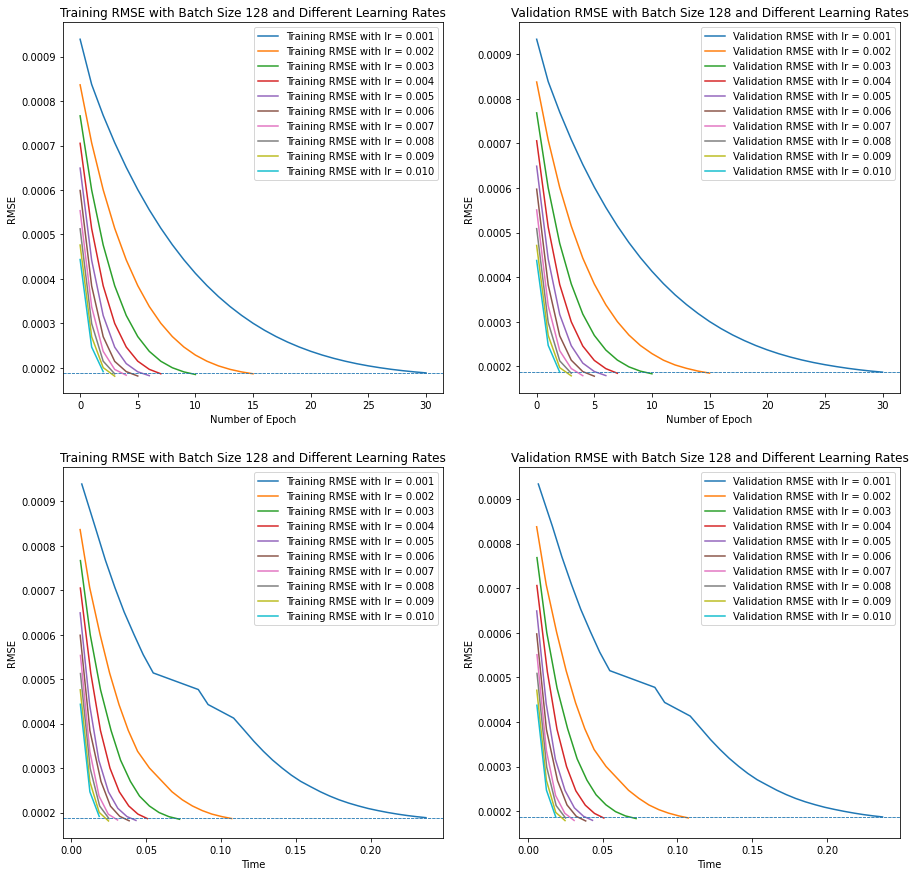

In [16]:
## Creating plots for a sweep of alpha from 0.001 to 0.01
fig, axes = plt.subplots(2, 2, figsize=(15,15))

for i in np.arange(0.001, 0.0101, 0.001):
    w, rmse_train, rmse_test, time_arr = mini_batch_GD(X_train, y_train, X_test, 
                                                    y_test, 128, i, ct, 20000)
    str_i = "{:.3f}".format(i)
    axes.flat[0].plot(rmse_train, label='Training RMSE with lr = ' + str_i)
    axes.flat[0].axhline(y=ct, linestyle = '--', linewidth = 0.8, alpha = 0.2)
    axes.flat[0].legend(loc='upper right')
    axes.flat[0].set(title='Training RMSE with Batch Size 128 and Different Learning Rates',
                    xlabel='Number of Epoch',
                    ylabel='RMSE')
    axes.flat[1].plot(rmse_test, label='Validation RMSE with lr = ' + str_i)
    axes.flat[1].axhline(y=ct, linestyle = '--', linewidth = 0.8, alpha = 0.2)
    axes.flat[1].legend(loc='upper right')
    axes.flat[1].set(title='Validation RMSE with Batch Size 128 and Different Learning Rates',
                    xlabel='Number of Epoch',
                    ylabel='RMSE')
    axes.flat[2].plot(time_arr, rmse_train, label='Training RMSE with lr = ' + str_i)
    axes.flat[2].axhline(y=ct, linestyle = '--', linewidth = 0.8, alpha = 0.2)
    axes.flat[2].legend(loc='upper right')
    axes.flat[2].set(title='Training RMSE with Batch Size 128 and Different Learning Rates',
                    xlabel='Time',
                    ylabel='RMSE')
    axes.flat[3].plot(time_arr, rmse_test, label='Validation RMSE with lr = ' + str_i)
    axes.flat[3].axhline(y=ct, linestyle = '--', linewidth = 0.8, alpha = 0.2)
    axes.flat[3].legend(loc='upper right')
    axes.flat[3].set(title='Validation RMSE with Batch Size 128 and Different Learning Rates',
                    xlabel='Time',
                    ylabel='RMSE')

Findings and main takeaways:
- In comparison, we can see that all RMSE curves in both training and validation groups are highly similar to their corresponding counterpart respectively;
- As the learning rate increase from 0.001 to 0.01, we can see that the RMSE curves have steeper slopes and faster convergence;
- As the learning rate decreases, the respective RMSE curve becomes smoother compared to the curve with a larger alpha;
- Larger learning rate within reasonable range leads to steeper descend of RMSE curve and much faster training time to reach convergence threshold.

## Part 6 - Gradient Descent with Adaptive Learning Rate [4 marks]
Implement an adaptive learning rate scheme where you start a mini-batch gradient descent with a large learning rate and decrease the learning rate while you are getting closer to the local minima. It's up to you to come up with a way to set **when** and **how much** do you want to change the learning rate. 
Our goal is to find a method for faster convergence. 
  1. Describe **[1]** and implement **[1]** your method.
  2. Plot the training and validation RMSE vs **epoch** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**
  3. Plot the training and validation RMSE vs **time** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**

The scheme/method that I use is as follows:
- Check the validation RMSE against the CT threshold after each epoch;
- Once the validation RMSE descends to within 5% of the CT, divide the learning rate by half;
- If the next epoch does not bring the validation RMSE to less than or equal to CT, divide the learning rate by half again;
- Repeat the above two steps until convergence.

In [17]:
## Main function for Part 6
def adaptive_lr_MBGD(training_data: np.ndarray, training_target: np.ndarray,
                  validation_data: np.ndarray, validation_target: np.ndarray,
                  batch_size: int, learning_rate: float, 
                  convergence_threshold: float, max_iter = 20000):
    ## Initialization
    np.random.seed(2)
    start_time = time.time()
    time_arr = []
    rmse_train = []
    rmse_test = []
    n = training_data.shape[0]
    w = (np.random.random(training_data.shape[1])/10000).reshape(1,-1)
    iter = 0
    row_num = 0

    ## Start of iteration
    while iter <= max_iter:
        ## Shuffle training data before each epoch
        xShuffled, yShuffled = shuffle(training_data, training_target)

        ## Start of each epoch
        for i in range(0, xShuffled.shape[0], batch_size):
            X_batch = xShuffled[i:i+batch_size]
            y_batch = yShuffled[i:i+batch_size]
            ytrain_mb = np.dot(X_batch, w.T).reshape(-1,1)
            gradient = (1/len(ytrain_mb) * np.dot(X_batch.T, ytrain_mb-y_batch)).reshape(1,-1)
            w = w - learning_rate * gradient ## Update weights
            iter += 1
            row_num = i

        if row_num < n: ## Consider cases when the last mini batch has less rows than batch size
            X_batch = xShuffled[row_num:]
            y_batch = yShuffled[row_num:]
            ytrain_mb = np.dot(X_batch, w.T).reshape(-1,1)
            gradient = (1/len(ytrain_mb) * np.dot(X_batch.T, ytrain_mb-y_batch)).reshape(1,-1)
            w = w - learning_rate * gradient ## Update weights
            iter += 1

        ## Collect info at the end of each epoch
        epoch_time = time.time() - start_time
        time_arr.append(epoch_time)

        ## Compute training RMSE
        ytrain_ep = np.dot(training_data, w.T).reshape(-1,1)
        rmse_train_ep = rmse(ytrain_ep, training_target)
        rmse_train.append(rmse_train_ep)

        ## Compute validation RMSE
        ytest_ep = np.dot(validation_data, w.T).reshape(-1,1)
        rmse_test_ep = rmse(ytest_ep, validation_target)
        rmse_test.append(rmse_test_ep)

        ## Increase learning rate each epoch if validation RMSE is far from threshols
        if rmse_test_ep >= (3 * convergence_threshold):
            learning_rate = learning_rate * 1.2

        ## Decrease learning rate each epoch
        ## once the validation RMSE comes close within 5% of the threshold
        if rmse_test_ep <= (1.05 * convergence_threshold):
            learning_rate = learning_rate * 0.6
        elif rmse_test_ep <= (1.025 * convergence_threshold):
            learning_rate = learning_rate * 0.8
        elif rmse_test_ep <= (1.001 * convergence_threshold):
            learning_rate = learning_rate * 0.95

        ## Check against threshold
        if rmse_test_ep <= convergence_threshold:
            break

    return w, rmse_train, rmse_test, time_arr, learning_rate

In [18]:
# ## Testing RMSprop
#
# def adaptive_lr_MBGD(training_data, training_target,
#                   validation_data, validation_target,
#                   batch_size, convergence_threshold, 
#                   learning_rate, gamma, max_iter = 20000):
#   ## Initialization
#   np.random.seed(2)
#   start_time = time.time()
#   time_arr = []
#   rmse_train = []
#   rmse_test = []
#   n = training_data.shape[0]
#   w = (np.random.random(training_data.shape[1])/10000).reshape(1,-1)
#   iter = 0
#   row_num = 0
#   mean_square = 0

#   ## Start of iteration
#   while iter <= max_iter:
#     ## Shuffle training data before each epoch
#     xShuffled, yShuffled = shuffle(training_data, training_target)
    
#     ## Start of each epoch
#     for i in range(0, xShuffled.shape[0], batch_size):
#       X_batch = xShuffled[i:i+batch_size]
#       y_batch = yShuffled[i:i+batch_size]
#       ytrain_mb = np.dot(X_batch, w.T).reshape(-1,1)
#       gradient = (1/len(ytrain_mb) * np.dot(X_batch.T, ytrain_mb-y_batch)).reshape(1,-1)
#       mean_square = gamma * mean_square + (1 - gamma) * np.square(gradient)
#       w = w - (learning_rate / np.sqrt(mean_square + 1e-8)) * gradient ## Update weights
#       iter += 1
#       row_num = i

#     if row_num < n: ## Consider cases when the last mini batch has less rows than batch size
#       X_batch = xShuffled[row_num:]
#       y_batch = yShuffled[row_num:]
#       ytrain_mb = np.dot(X_batch, w.T).reshape(-1,1)
#       gradient = (1/len(ytrain_mb) * np.dot(X_batch.T, ytrain_mb-y_batch)).reshape(1,-1)
#       mean_square = gamma * mean_square + (1 - gamma) * np.square(gradient)
#       w = w - (learning_rate / np.sqrt(mean_square + 1e-8)) * gradient ## Update weights
#       iter += 1

#     ## Collect info at the end of each epoch
#     epoch_time = time.time() - start_time
#     time_arr.append(epoch_time)

#     ## Compute training RMSE
#     ytrain_ep = np.dot(training_data, w.T).reshape(-1,1)
#     rmse_train_ep = rmse(ytrain_ep, training_target)
#     rmse_train.append(rmse_train_ep)

#     ## Compute validation RMSE
#     ytest_ep = np.dot(validation_data, w.T).reshape(-1,1)
#     rmse_test_ep = rmse(ytest_ep, validation_target)
#     rmse_test.append(rmse_test_ep)

#     ## Update learning rate by 0.5 (half of previous) each epoch
#     ## once the validation RMSE comes close within 5% of the threshold
#     # if rmse_test_ep <= (1.05 * convergence_threshold):
#     #   learning_rate = learning_rate * 0.5

#     ## Check against threshold
#     if rmse_test_ep <= convergence_threshold:
#       break
    
#   return w, rmse_train, rmse_test, time_arr, learning_rate

In [19]:
## Set up appropriate batch size (use batch size upwards of 1024 would show the 
## differences better) and initial learning rate (ranging from 0.03 to 0.1, cannot be too small) for the adaptive model.
## Adaptive model works better with larger batch sizes (for updating learning rate) and larger initial alpha.
## Static model is using 0.01 as alpha (fastest convergence from Part 5).

## Collect the training and validation results from both models
w_lr, rmse_train_lr, rmse_test_lr, time_arr_lr, lr = adaptive_lr_MBGD(X_train, y_train, X_test, y_test, 2048, 0.03, ct, 20000)
w, rmse_train, rmse_test, time_arr = mini_batch_GD(X_train, y_train, X_test, y_test, 2048, 0.01, ct, 20000)

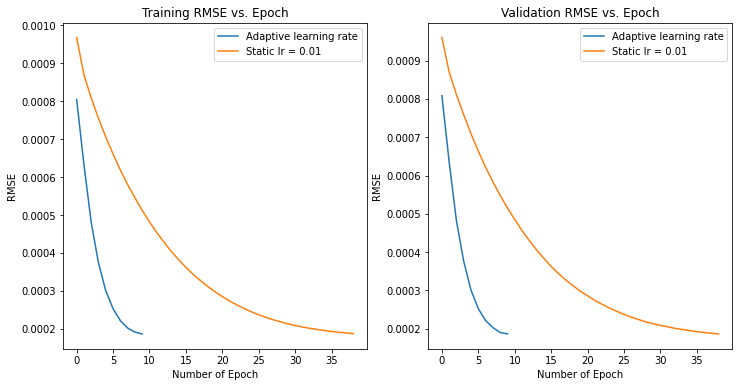

In [20]:
## Compare training and validation RMSE curves vs. epoch for adaptive approach vs. static learning rate approach
fig, axes = plt.subplots(1, 2, figsize=(12,6))

str_i = "{:.2f}".format(0.01) ## Change according to static learning rate

axes.flat[0].plot(rmse_train_lr, label='Adaptive learning rate')
axes.flat[0].plot(rmse_train, label='Static lr = ' + str_i)
axes.flat[0].set(title='Training RMSE vs. Epoch',
                 xlabel='Number of Epoch',
                 ylabel='RMSE')
axes.flat[0].legend(loc='upper right')

axes.flat[1].plot(rmse_test_lr, label='Adaptive learning rate')
axes.flat[1].plot(rmse_test, label='Static lr = ' + str_i)
axes.flat[1].set(title='Validation RMSE vs. Epoch',
                 xlabel='Number of Epoch',
                 ylabel='RMSE')
axes.flat[1].legend(loc='upper right')

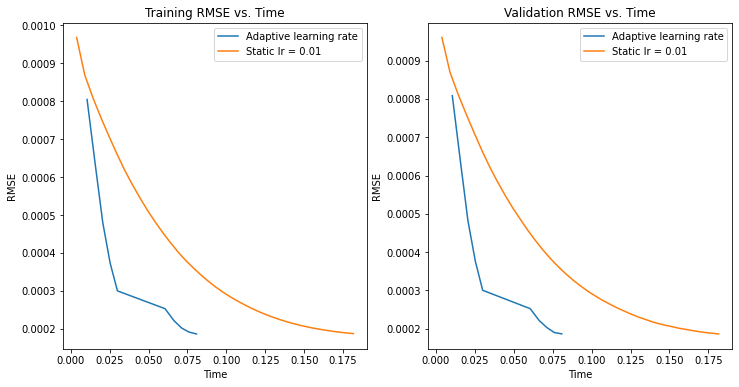

In [21]:
## Compare training and validation RMSE curves vs. time for adaptive approach vs. static learning rate approach
fig, axes = plt.subplots(1, 2, figsize=(12,6))

str_i = "{:.2f}".format(0.01) ## Change according to static learning rate

axes.flat[0].plot(time_arr_lr, rmse_train_lr, label='Adaptive learning rate')
axes.flat[0].plot(time_arr, rmse_train, label='Static lr = ' + str_i)
axes.flat[0].set(title='Training RMSE vs. Time',
                 xlabel='Time',
                 ylabel='RMSE')
axes.flat[0].legend(loc='upper right')

axes.flat[1].plot(time_arr_lr, rmse_test_lr, label='Adaptive learning rate')
axes.flat[1].plot(time_arr, rmse_test, label='Static lr = ' + str_i)
axes.flat[1].set(title='Validation RMSE vs. Time',
                 xlabel='Time',
                 ylabel='RMSE')
axes.flat[1].legend(loc='upper right')

We can see that using the adaptive learning rate method leads to much faster convergence with fewer epochs required in general. However, the function in this part cannot take an initial learning rate less than 0.03.

## Part 7 - Gradient Descent with Additional Features and Regularization [3 marks]

Now, we'll apply linear regresssion to a toy dataset (`LR_data.csv`), with 10 features `x1`-`x10` and a "measurement" `y`. We'll take a few shortcuts by using built-in sklearn functions.

1. Data Preparation **[0.5]**
  * Print the dataset, and create Numpy arrays with inputs (X) and outputs (y). 
  * Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.

2. Linear Regression **[0.5]**
  * Standardize the data using StandardScaler from sklearn.
  * Use the `sklearn.linear_model.LinearRegression` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to perform linear regression.
  * Print the RMSE for training and validation data.

3. Linear Regression with Additional Features **[0.5]**
  * Let's add more features to our dataset (up to degree 8) using `sklearn.preprocessing.PolynomialFeatures` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). You'll want to create the additional features first, then perform standardization (start from non-standardized data).
  * Again, use `sklearn.linear_model.LinearRegression` to perform linear regression.
  * Print the RMSE for training and validation data.

4. Linear Regression with Additional Features and Regularization **[0.5]**
  * Let's switch models, and instead use the `sklearn.linear_model.Ridge` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) to perform linear regression with regularization. Apply the model to the processed data (additional, standardized) you used in 3 above. Use a `FOR` loop to run `sklearn.linear_model.Ridge` with different `alpha` values. Specifically, sweep `alpha` from 1E-2 to 1E10 (each step is an order of magnitude jump).

5. Discuss your results. What do you conclude? **[1]**

In [22]:
import pandas as pd
df=pd.read_csv("https://www.eecg.utoronto.ca/~hadizade/APS1070/LR_data.csv" , skipinitialspace=True)

In [23]:
df.head(10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.454481,4.940543,7.116015,3.805131,4.105432,1.832290,5.211909,5.088293,3.841250,6.121133,6.575066e+06
1,4.907182,1.653654,7.339445,9.065282,7.169233,2.354136,2.893005,8.720131,8.646473,3.806860,8.419881e+06
2,1.842804,1.183878,4.203206,6.815847,6.655899,8.295816,3.556779,5.794679,3.260723,5.463808,9.745537e+04
3,2.393457,0.094127,3.208929,0.497443,4.318127,4.999247,9.470238,3.061990,7.312995,5.475240,1.129200e+04
4,5.093724,3.905293,4.858562,4.465484,0.947091,9.410307,8.137329,9.043838,9.128607,0.790795,3.105448e+05
5,0.375957,3.489081,7.262106,6.306018,5.907472,0.988894,8.231835,8.265774,8.669483,1.254743,7.735764e+06
6,9.577222,9.428066,2.681789,1.625122,5.400703,0.052908,5.310164,4.758203,5.493273,0.461270,3.149807e+03
7,1.338110,0.583168,6.269942,9.864809,0.729452,3.910690,1.076602,9.200548,4.011550,9.206116,2.388450e+06
8,8.342222,5.926632,5.755885,5.764966,7.684441,1.975542,2.124600,0.045201,6.406578,3.228309,1.204890e+06
9,7.554502,5.720743,0.348854,8.459366,4.209461,2.389532,1.436743,9.619647,2.951377,5.458826,1.492802e+02


In [24]:
## Train-Validation split (80/20)
df_copy = df.copy(deep=True)
X = df_copy.iloc[:,:-1]
y = df_copy.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [25]:
## Standardization
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## Insert bias column
X_train_std = np.insert(X_train_std, 0, np.ones(X_train_std.shape[0]), axis=1)
X_test_std = np.insert(X_test_std, 0, np.ones(X_test_std.shape[0]), axis=1)

In [26]:
## Linear Regression
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train_std, y_train)

y_pred_train = LR.predict(X_train_std)
y_pred_val = LR.predict(X_test_std)

print("The RMSE for training data is: ", rmse(y_pred_train, y_train))
print("The RMSE for validation data is: ", rmse(y_pred_val, y_test))

The RMSE for training data is:  16296980.655667374
The RMSE for validation data is:  14061578.864980092


In [27]:
## Linear Regression with Additional Features
from sklearn.preprocessing import PolynomialFeatures

## Add poly features
poly = PolynomialFeatures(8)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

## Standardization
X_train_poly_std = sc.fit_transform(X_train_poly)
X_test_poly_std = sc.transform(X_test_poly)

## Insert bias column
# X_train_poly_std = np.insert(X_train_poly_std, 0, np.ones(X_train_poly_std.shape[0]), axis=1)
# X_test_poly_std = np.insert(X_test_poly_std, 0, np.ones(X_test_poly_std.shape[0]), axis=1)

LR_poly = LinearRegression()
LR_poly.fit(X_train_poly_std, y_train)

y_pred_train_poly = LR_poly.predict(X_train_poly_std)
y_pred_val_poly = LR_poly.predict(X_test_poly_std)

print("The RMSE for training data is: ", rmse(y_pred_train_poly, y_train))
print("The RMSE for validation data is: ", rmse(y_pred_val_poly, y_test))

The RMSE for training data is:  1.1154878119198678e-07
The RMSE for validation data is:  10920908.905406754


In [28]:
## Linear Regression with Additional Features and Regularization
from sklearn.linear_model import Ridge

ridge_train_rmse = []
ridge_val_rmse = []

for i in np.arange(-2, 11, dtype=float):
    alpha = 10 ** i
    ridge_model = Ridge(alpha)
    ridge_model.fit(X_train_poly_std, y_train)
    y_pred_train_ridge = ridge_model.predict(X_train_poly_std)
    y_pred_val_ridge = ridge_model.predict(X_test_poly_std)
    rtrain_rmse = rmse(y_pred_train_ridge, y_train)
    rval_rmse = rmse(y_pred_val_ridge, y_test)
    ridge_train_rmse.append(rtrain_rmse)
    ridge_val_rmse.append(rval_rmse)

print(ridge_train_rmse)
print(ridge_val_rmse)

[321.01240916309644, 3199.3496468416506, 30988.518341657847, 248080.3696494477, 1196923.6228686073, 3609078.2596920887, 7712389.432217537, 14600498.520348776, 20036025.00599003, 22910819.324746832, 23435716.156519353, 23494007.189870406, 23499904.341360077]
[10919504.125893764, 10916171.329033064, 10884651.018827904, 10659707.103878867, 9484394.22011948, 5633182.875138311, 4521905.583502402, 10502863.775565729, 16057627.104454402, 18700005.54478621, 19178033.464494962, 19231116.414978746, 19236486.536391094]


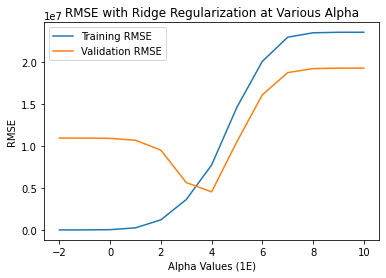

In [29]:
## Plotting the training and validation RMSE curves with Ridge regularization
alpha_pow = np.arange(-2, 11, dtype=float)
plt.plot(alpha_pow, ridge_train_rmse, label='Training RMSE')
plt.plot(alpha_pow, ridge_val_rmse, label='Validation RMSE')
plt.title('RMSE with Ridge Regularization at Various Alpha')
plt.xlabel('Alpha Values (1E)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

From the above plot of training and validation RMSE curves, it is clear that the Ridge regularizer with an alpha of 1E4 successfully bring down the validation RMSE from around 10920000 to about 4521905, which is a big step down in error. Although larger alpha values lead to higher training and validation RMSE (overfitting) again, we can still see the obvious effect of ridge regularization (it does improve model performance).

## Part 8 - Linear Regression with a Custom Dataset [2 marks]


Find a dataset online and train and validate a linear regression model with the techniques you learned in this Project.

*   Introduce your dataset.**[0.5]**
*   Explain your approach. **[0.5]**
*   Summarize your results. **[1]**

Hint: you can find various datasets in here: https://www.kaggle.com/datasets.

To use a dataset in Colab, you can upload it in your Google drive and access it in Colab ([help here](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a)), or you can download the dataset on your local machine and upload it directly to Colab using the following script.

```
from google.colab import files
uploaded = files.upload()
```

When submitting your project on Quercus, Please make sure you are also uploading your dataset so we can fully run your notebook.






The dataset used in the analysis below is the Boston House Prices Dataset from sklearn.datasets with 506 rows and 13 features. This dataset has the following features:
- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per $10,000
- PTRATIO pupil-teacher ratio by town
- B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT % lower status of the population

The target (y) is:
- MEDV Median value of owner-occupied homes in (by 1000 dollars)

I intend to utilize the following methods after 80/20 train-validation split and standardization:
- Direct solution (similar to the tutorial code)
- Standard linear regression
- Stochastic gradient descent regression
- Adding polynomial features before linear regression
- Optimize the best model from the above list using Ridge regularization

After all the above steps, we can see what is the best RMSE scores of the Boston House Prices data using sklearn models learned from this project.

In [30]:
## Using Boston Housing Data from sklearn datasets
from sklearn.datasets import load_boston

boston_dataset = load_boston()
X = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
X.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [31]:
X.shape

(506, 13)

In [32]:
y = boston_dataset.target
y[0:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [33]:
# Train-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Standardization
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## Insert bias column
X_train_std = np.insert(X_train_std, 0, np.ones(X_train_std.shape[0]), axis=1)
X_test_std = np.insert(X_test_std, 0, np.ones(X_test_std.shape[0]), axis=1)

In [34]:
## using direct solution to check RMSE scores
W_ds = np.dot(inv(np.dot(X_train_std.T, X_train_std)), np.dot(X_train_std.T, y_train))

ytrainPred = np.dot(X_train_std, W_ds)
ytestPred = np.dot(X_test_std, W_ds)

## ct = 1.001 * rmse(ytestPred, y_test)

print('RMSE for training sets with direct solution: ', rmse(ytrainPred, y_train))
print('RMSE for validation sets with direct solution: ', rmse(ytestPred, y_test))

RMSE for training sets with direct solution:  4.675766751547773
RMSE for validation sets with direct solution:  4.835373458200534


In [35]:
## Check RMSE using standard Linear Regression
LR = LinearRegression()
LR.fit(X_train_std, y_train)

y_pred_train = LR.predict(X_train_std)
y_pred_val = LR.predict(X_test_std)

print("The RMSE for training data with LR is: ", rmse(y_pred_train, y_train))
print("The RMSE for validation data with LR is: ", rmse(y_pred_val, y_test))

The RMSE for training data with LR is:  4.675766751547773
The RMSE for validation data with LR is:  4.835373458200538


In [36]:
## Check RMSE using Stochastic Gradient Descent Regression
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
sgd.fit(X_train_std, y_train)

y_pred_train_sgd = sgd.predict(X_train_std)
y_pred_val_sgd = sgd.predict(X_test_std)

print("The RMSE for training data with SGD is: ", rmse(y_pred_train_sgd, y_train))
print("The RMSE for validation data with SGD is: ", rmse(y_pred_val_sgd, y_test))

The RMSE for training data with SGD is:  4.685692962749388
The RMSE for validation data with SGD is:  4.838108692406656


In [37]:
## Check RMSE using Polynomial Features
def poly_reg(degree):
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    ## Standardization
    X_train_poly_std = sc.fit_transform(X_train_poly)
    X_test_poly_std = sc.transform(X_test_poly)

    ## Insert bias column
    # X_train_poly_std = np.insert(X_train_poly_std, 0, np.ones(X_train_poly_std.shape[0]), axis=1)
    # X_test_poly_std = np.insert(X_test_poly_std, 0, np.ones(X_test_poly_std.shape[0]), axis=1)

    LR_poly = LinearRegression()
    LR_poly.fit(X_train_poly_std, y_train)

    y_pred_train_poly = LR_poly.predict(X_train_poly_std)
    y_pred_val_poly = LR_poly.predict(X_test_poly_std)

    print(f"The RMSE for training data with Polynomial degree of {i} is: {rmse(y_pred_train_poly, y_train)}")
    print(f"The RMSE for validation data with Polynomial degree of {i} is: {rmse(y_pred_val_poly, y_test)}")

## Test polynomial degree to see which one works better
for i in [2, 3, 4]:
    poly_reg(i)

The RMSE for training data with Polynomial degree of 2 is: 2.4382638501906464
The RMSE for validation data with Polynomial degree of 2 is: 2.9553221974322987
The RMSE for training data with Polynomial degree of 3 is: 1.6519041935543564e-11
The RMSE for validation data with Polynomial degree of 3 is: 39.92167278242836
The RMSE for training data with Polynomial degree of 4 is: 8.831618635521033e-13
The RMSE for validation data with Polynomial degree of 4 is: 17.039677434265016


Now we can see that the model using a Polynomial degree of 2 produces better training and validation RMSE scores than the standard LR and SGD approaches.

In [38]:
## Poly Regression with degree = 2
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

## Standardization
X_train_poly_std = sc.fit_transform(X_train_poly)
X_test_poly_std = sc.transform(X_test_poly)

## Insert bias column
# X_train_poly_std = np.insert(X_train_poly_std, 0, np.ones(X_train_poly_std.shape[0]), axis=1)
# X_test_poly_std = np.insert(X_test_poly_std, 0, np.ones(X_test_poly_std.shape[0]), axis=1)

LR_poly = LinearRegression()
LR_poly.fit(X_train_poly_std, y_train)

y_pred_train_poly = LR_poly.predict(X_train_poly_std)
y_pred_val_poly = LR_poly.predict(X_test_poly_std)

print(f"The RMSE for training data with Polynomial degree of 2 is: {rmse(y_pred_train_poly, y_train)}")
print(f"The RMSE for validation data with Polynomial degree of 2 is: {rmse(y_pred_val_poly, y_test)}")

The RMSE for training data with Polynomial degree of 2 is: 2.4382638501906464
The RMSE for validation data with Polynomial degree of 2 is: 2.9553221974322987


In [39]:
## Optimization using Ridge regularization
ridge_train_rmse = []
ridge_val_rmse = []
alpha_pow = np.arange(0, 2, 0.1, dtype=float)

for i in alpha_pow:
    ridge_model = Ridge(i)
    ridge_model.fit(X_train_poly_std, y_train)
    y_pred_train_ridge = ridge_model.predict(X_train_poly_std)
    y_pred_val_ridge = ridge_model.predict(X_test_poly_std)
    rtrain_rmse = rmse(y_pred_train_ridge, y_train)
    rval_rmse = rmse(y_pred_val_ridge, y_test)
    ridge_train_rmse.append(rtrain_rmse)
    ridge_val_rmse.append(rval_rmse)

print(ridge_train_rmse)
print(ridge_val_rmse)

[2.440481050284336, 2.5365723281996755, 2.5955812455752856, 2.639155280289205, 2.674182670252301, 2.7037021609994283, 2.729342252922967, 2.752084712585902, 2.772570637963996, 2.791243697201277, 2.8084248031553507, 2.8243542929631467, 2.8392172826286344, 2.8531596873054363, 2.866298766896739, 2.8787303100009147, 2.8905336725591417, 2.901775401658421, 2.912511899319865, 2.9227914185088584]
[2.9546495452273707, 2.8793317172932014, 2.812865994950098, 2.7655718766959483, 2.7323980113324446, 2.7090424866595857, 2.692620407995779, 2.6812100670630814, 2.6735029155765666, 2.668585170458977, 2.665803545783918, 2.664681113859404, 2.6648632099415326, 2.666081755580529, 2.6681311689877387, 2.670851749396949, 2.6741179951534066, 2.677830247853347, 2.6819086218333483, 2.6862885312780094]


The lowest validation RMSE is 2.664681113859404 with a training RMSE of 2.8243542929631467 at Ridge alpha value at 1.1


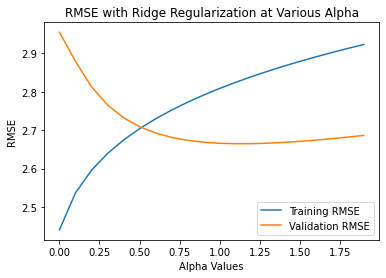

In [40]:
print('The lowest validation RMSE is', min(ridge_val_rmse), 
      'with a training RMSE of', ridge_train_rmse[np.argmin(ridge_val_rmse)],
      'at Ridge alpha value at', 0.1*np.argmin(ridge_val_rmse))

## Plotting the training and validation RMSE curves with Ridge regularization
plt.plot(alpha_pow, ridge_train_rmse, label='Training RMSE')
plt.plot(alpha_pow, ridge_val_rmse, label='Validation RMSE')
plt.title('RMSE with Ridge Regularization at Various Alpha')
plt.xlabel('Alpha Values')
plt.ylabel('RMSE')
plt.legend()
plt.show()

After implementing the above models and Ridge optimization, the minimum validation RMSE is about 2.665, which is achieved by:
- Standardization;
- Adding polynomial of degree 2 to the linear regression model;
- Adding Ridge optimization at alpha = 1.1.

However, from the above train vs. validation RMSE plot, we can see that the best model might be somewhere between Ridge values of 0.5 to 1.1 because the two RMSE curves intersect at alpha = 0.5. After that point, the Ridge regularized model seems to be increasingly overfitting (train RMSE larger than validation RMSE).